In [49]:
import tensorflow as tf


train_data = tf.keras.utils.image_dataset_from_directory(
    "./train",
    label_mode="categorical",
    image_size=(150, 150),
    shuffle=False,
    seed=0
)

valid_data = tf.keras.utils.image_dataset_from_directory(
    "./valid",  # Specify the path to your validation data directory
    label_mode="categorical",
    image_size=(150, 150),
    shuffle=False,
    seed=0
)

test_data = tf.keras.utils.image_dataset_from_directory(
    "./test",
    label_mode="categorical",
    image_size=(150, 150),
    shuffle=False,
    seed=0
)


Found 6552 files belonging to 102 classes.
Found 818 files belonging to 102 classes.
Found 819 files belonging to 102 classes.


In [50]:
classes = train_data.class_names
n_classes = len(classes)
n_classes

102

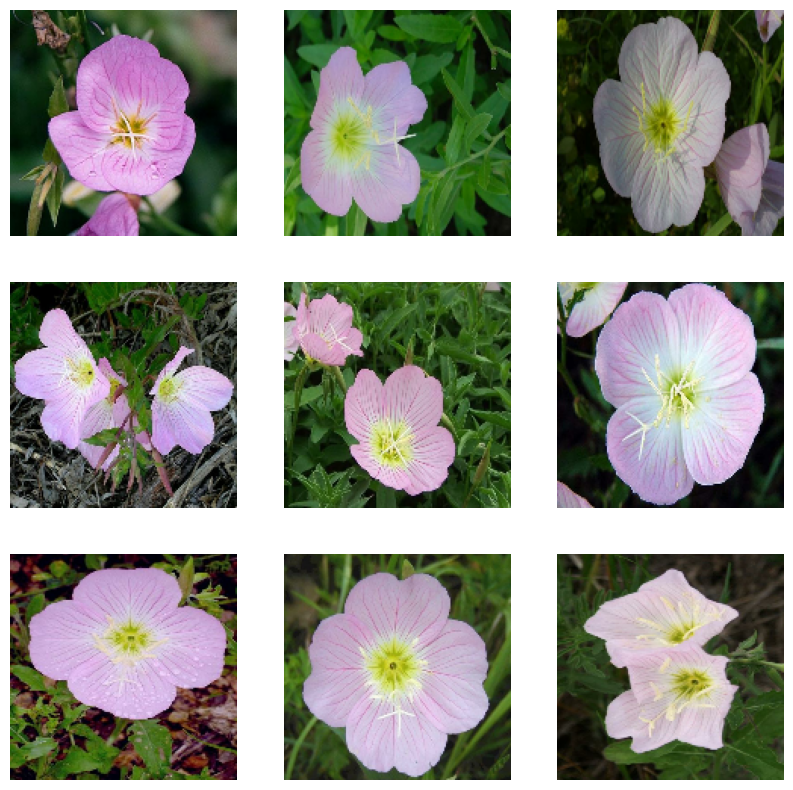

In [51]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt



images, labels = next(iter(train_data.take(1)))  # Take a batch of images

plt.figure(figsize=(10, 10))  # Create a canvas

for i in range(9):
    plt.subplot(3, 3, i + 1)  # Plotting the i+1 image in a 3x3 canvas
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")  # Turn off axis for better visualization

plt.show()


In [52]:
n_batches = valid_data.cardinality()
n_batches

<tf.Tensor: shape=(), dtype=int64, numpy=26>

In [53]:
for transform in [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)]:
    
    train_data = train_data.map(lambda x, y: (transform(x), y))

In [54]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from kerastuner.tuners import RandomSearch

# Assuming n_classes is defined somewhere in your code


def create_model(hp=None):
    base_model = Xception(
        weights="imagenet",
        input_shape=(150, 150, 3),
        include_top=False,
    )

    base_model.trainable = False

    inputs = tf.keras.Input(shape=(150, 150, 3))
    scaling = layers.Rescaling(scale=1 / 127.5, offset=-1)
    outputs = scaling(inputs)
    outputs = base_model(outputs, training=False)
    outputs = layers.GlobalAveragePooling2D()(outputs)

    hp_layers = hp.Int("layers", min_value=1, max_value=3, step=1) if hp else 1
    hp_units = hp.Int("units", min_value=32, max_value=128, step=32) if hp else 32
    
    for _ in range(hp_layers):
        outputs = layers.Dense(hp_units, activation='relu')(outputs)

    outputs = layers.Dense(n_classes, activation='softmax')(outputs)
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )

    return model

model = create_model()
model.summary(show_trainable=True)


Model: "model_6"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d_6  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dense_15 (Dense)            (None, 32)                6556

In [55]:
for transform in [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
]:
    train_data = train_data.map(lambda x, y: (transform(x), y))

In [56]:
# !pip install keras-tuner

import keras_tuner as kt
import numpy as np

tuner = kt.Hyperband(
    hypermodel=create_model,
    objective="categorical_accuracy",
    max_epochs=10,
    factor=3,
    project_name="flower_hp"
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

X_train = np.concatenate([x for x, _ in train_data], axis=0)
y_train = np.concatenate([y for _, y in train_data], axis=0)

X_valid = np.concatenate([x for x, _ in valid_data], axis=0)
y_valid = np.concatenate([y for _, y in valid_data], axis=0)

X_test = np.concatenate([x for x, _ in test_data], axis=0)
y_test = np.concatenate([y for _, y in test_data], axis=0)

tuner.search(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from .\flower_hp\tuner0.json


In [57]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=10)

Epoch 1/10
205/205 [==============================] - 526s 3s/step - loss: 4.0656 - categorical_accuracy: 0.1503 - val_loss: 3.3390 - val_categorical_accuracy: 0.2665
Epoch 2/10
205/205 [==============================] - 479s 2s/step - loss: 2.8659 - categorical_accuracy: 0.3765 - val_loss: 2.4061 - val_categorical_accuracy: 0.4328
Epoch 3/10
205/205 [==============================] - 435s 2s/step - loss: 2.1431 - categorical_accuracy: 0.5102 - val_loss: 1.9667 - val_categorical_accuracy: 0.5122
Epoch 4/10
205/205 [==============================] - 490s 2s/step - loss: 1.7316 - categorical_accuracy: 0.5856 - val_loss: 1.7332 - val_categorical_accuracy: 0.5452
Epoch 5/10
205/205 [==============================] - 601s 3s/step - loss: 1.4632 - categorical_accuracy: 0.6433 - val_loss: 1.5805 - val_categorical_accuracy: 0.5721
Epoch 6/10
205/205 [==============================] - 513s 3s/step - loss: 1.2650 - categorical_accuracy: 0.6906 - val_loss: 1.4210 - val_categorical_accuracy: 0.625

In [58]:
val_acc_per_epoch = history.history["val_categorical_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch))

Best epoch: 9


In [59]:
hypermodel = tuner.hypermodel.build(best_hps)
history_hypermodel=hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_valid, y_valid))

Epoch 1/9
205/205 [==============================] - 435s 2s/step - loss: 4.1062 - categorical_accuracy: 0.1377 - val_loss: 3.4658 - val_categorical_accuracy: 0.2469
Epoch 2/9
205/205 [==============================] - 449s 2s/step - loss: 3.0157 - categorical_accuracy: 0.3413 - val_loss: 2.5279 - val_categorical_accuracy: 0.4438
Epoch 3/9
205/205 [==============================] - 634s 3s/step - loss: 2.2342 - categorical_accuracy: 0.4913 - val_loss: 2.0149 - val_categorical_accuracy: 0.5049
Epoch 4/9
205/205 [==============================] - 697s 3s/step - loss: 1.7693 - categorical_accuracy: 0.5904 - val_loss: 1.7231 - val_categorical_accuracy: 0.5648
Epoch 5/9
205/205 [==============================] - 678s 3s/step - loss: 1.4770 - categorical_accuracy: 0.6505 - val_loss: 1.5527 - val_categorical_accuracy: 0.6064
Epoch 6/9
205/205 [==============================] - 760s 4s/step - loss: 1.2771 - categorical_accuracy: 0.6903 - val_loss: 1.4175 - val_categorical_accuracy: 0.6333
Epoc

In [60]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

26/26 [==============================] - 67s 3s/step - loss: 1.3356 - categorical_accuracy: 0.6361
[test loss, test accuracy]: [1.335599660873413, 0.6361416578292847]


In [61]:
import numpy as np

def predict(path):
    image = tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    predicted = model.predict(image)[0].argmax(axis=-1)
    return classes[predicted]

predict("test/8/image_03319.jpg")

1/1 [==============================] - 6s 6s/step


'8'

In [67]:
# Assuming hypermodel is a Keras Functional model

# Training score
training_results = hypermodel.evaluate(X_train, y_train)
training_loss = training_results[0]  # Assuming loss is the first element in the results
training_accuracy = training_results[1]  # Assuming accuracy is the second element in the results
print(f'Training Loss: {training_loss}, Training Accuracy: {training_accuracy}')

# Test score
test_results = hypermodel.evaluate(X_test, y_test)
test_loss = test_results[0]  # Assuming loss is the first element in the results
test_accuracy = test_results[1]  # Assuming accuracy is the second element in the results
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


205/205 [==============================] - 634s 3s/step - loss: 0.8118 - categorical_accuracy: 0.8053
Training Loss: 0.8117871284484863, Training Accuracy: 0.8052502870559692
26/26 [==============================] - 75s 3s/step - loss: 1.3356 - categorical_accuracy: 0.6361
Test Loss: 1.335599660873413, Test Accuracy: 0.6361416578292847


In [77]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

n_folds = 5

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = []

for train_index, test_index in kf.split(X_valid):
    X_train, X_test = X_valid[train_index], X_valid[test_index]
    y_train, y_test = y_valid[train_index], y_valid[test_index]

    y_pred = hypermodel.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    cv_scores.append(mse)

print("Cross-validation scores:", cv_scores)

mean_cv_score = np.mean(cv_scores)
print("Mean Cross-validation score:", mean_cv_score)


6/6 [==============================] - 11s 2s/step
Cross-validation scores: [0.004341518, 0.0045108385, 0.004125335, 0.003917634, 0.004431122]
Mean Cross-validation score: 0.0042652898
